In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
import math 

In [149]:
# Load the data into a dataframe

# Mode = ["Aligned", "Alignedv2"]
# Mode = ["Rotated", "Rot30v2"]
Mode = ["Shifted","Shiftedv2"]

meta = pd.read_csv(f"../Files/{Mode[0]}/Metadata_merge_{Mode[1]}.csv", delimiter = ",", names = ["event","electrons","ions","elastic","ionisations","attachment","inelastic","excitation","top","bottom","start x","start y","start z", "start E", "end E"])

display(meta)


event  electrons  ions    elastic  ionisations  attachment  inelastic  \
0         21          1     0  329779612            0           0          0   
1         22          1     0  345700665            0           0          0   
2         23          1     0  340027355            0           0          0   
3         24          1     0  336342574            0           0          0   
4         25          1     0  337187459            0           0          0   
...      ...        ...   ...        ...          ...         ...        ...   
39755  19996          1     0  350274573            0           0          0   
39756  19997          1     0  348402423            0           0          0   
39757  19998          1     0  338238774            0           0          0   
39758  19999          1     0  344665777            0           0          0   
39759  20000          1     0  341575058            0           0          0   

       excitation  top  bottom   start x   start y  start z   start E  \
0            1201    0       1  0.410589  0.157936     0.85  1.000000   
1            1130    0       1 -0.157715  0.224725     0.85  8.743929   
2            1162    0       1  0.284188  0.305848     0.85  2.664172   
3            1163    0       1  0.367905 -0.029396     0.85  3.432223   
4            1161    0       1  0.357818 -0.239819     0.85  7.032468   
...           ...  ...     ...       ...       ...      ...       ...   
39755        1121    0       1  0.109435 -0.416635     0.85  4.508085   
39756        1124    0       1  0.189803 -0.228414     0.85  2.689596   
39757        1165    0       1 -0.196005  0.274152     0.85  4.326979   
39758        1160    0       1 -0.077307 -0.351011     0.85  3.973080   
39759        1168    0       1 -0.103632 -0.333988     0.85  3.061612   

          end E  
0      3.937199  
1      5.408303  
2      7.674696  
3      2.123048  
4      0.757063  
...         ...  
39755  4.322140  
39756  7.594230  
39757  5.432274  
39758  6.426113  
39759  4.412842  

[39760 rows x 15 columns]

In [150]:
req_par = ['event', 'excitation', 'start x', 'start y']
meta_slim = meta[req_par]
pd.options.mode.chained_assignment = None  # default='warn'

# Flip the y axis
# meta_slim["start y"] = -meta_slim["start y"]

# Convert to mm before writing to file
meta_slim["start x"] = meta_slim["start x"].astype(float)*10
meta_slim["start y"] = meta_slim["start y"].astype(float)*10


hexsize = (1.25+0.127/2.0)/(np.cos(30*np.pi/180))
# hexsize = 15 # mm for rotated mode
print(hexsize)

# Calculate the nearest hexagon centre to the point
def hex_round(q,r,s,mode):
    qi = int(round(q))
    ri = int(round(r))
    si = int(round(s))
    q_diff = abs(qi - q)
    r_diff = abs(ri - r)
    s_diff = abs(si - s)
    
    if q_diff > r_diff and q_diff > s_diff:
        qi = -ri - si
    else:
        if r_diff > s_diff:
            ri = -qi - si
        else:
            si = -qi - ri
    
    if (mode == "q"):
        return qi
    elif (mode == "r"):
        return ri
    else:
        return si

# Calculate q and r values for meta_slim table
meta_slim["q"] = (meta_slim["start x"] * np.sqrt(3)/3.0 - 1.0/3.0*meta_slim["start y"]) / hexsize 
meta_slim["r"] = (2.0/3.0)*meta_slim["start y"] / hexsize
meta_slim["s"] = -meta_slim["q"] - meta_slim["r"]

# Calculate the multiple of q and r of the hexagon
meta_slim["nq"] = meta_slim.apply(lambda df: hex_round(df["q"], df["r"], df["s"], "q"), axis = "columns", result_type='expand' )
meta_slim["nr"] = meta_slim.apply(lambda df: hex_round(df["q"], df["r"], df["s"], "r"), axis = "columns", result_type='expand' )

# Shift the values to unit cell
meta_slim["q"] = meta_slim["q"] - meta_slim["nq"]
meta_slim["r"] = meta_slim["r"] - meta_slim["nr"]

# Drop columns that are now not needed
meta_slim = meta_slim.drop(columns = ["s", "nq","nr", "start x", "start y"])

# Store df for later use
meta_slim_copy = meta_slim.copy()
meta_slim = meta_slim.drop(columns = ["event"])

# Define bins in q and r space
numbins = 50

bins_q, bw_q  = np.linspace(-1, +1, numbins, retstep=True)
bins_centre_q = np.linspace(-1+bw_q/2, 1+bw_q/2, numbins)[:-1]

bins_r, bw_r  = np.linspace(-1, +1, numbins, retstep=True)
bins_centre_r = np.linspace(-1+bw_r/2, 1+bw_r/2, numbins)[:-1]

# Now bin the data
meta_slim['q'] = pd.cut(x=meta_slim['q'], bins=bins_q,labels=bins_centre_q, include_lowest=True)
meta_slim['r'] = pd.cut(x=meta_slim['r'], bins=bins_r,labels=bins_centre_r, include_lowest=True)

# Now average over the events
# meta_avg_ = meta_slim.groupby(['q', 'r']).mean()
# meta_avg_ = meta_avg_.fillna(0)
# meta_avg_.reset_index(inplace=True) 
meta_avg_ = meta_slim

# Kill all the rows that are empty
meta_avg = meta_avg_[meta_avg_['excitation'] != 0]

# Convert q and r back to x and y values (now should be in unit cell)
meta_avg["x"] = hexsize * (np.sqrt(3)*meta_avg["q"].astype(float) + 0.5*np.sqrt(3)*meta_avg["r"].astype(float))
meta_avg["y"] = hexsize * 1.5*meta_avg["r"].astype(float)


# Write the map to a file
meta_avg.to_hdf(f"../Maps/dist_unitcell_{Mode[1]}.h5","Yields", mode='w', format = "table")


display(meta_avg)

display(meta_avg[  (meta_avg["q"] == meta_avg.iloc[0].values[1]) & (meta_avg["r"] == meta_avg.iloc[0].values[2])])

print(meta_avg.iloc[0].values[1])


1.5166991571611466


/Users/mistryk2/opt/anaconda3/envs/local/lib/python3.10/site-packages/tables/file.py:426: UserWarning: a closed node found in the registry: ``/Yields/meta/values_block_1/meta/_i_table``
  warnings.warn("a closed node found in the registry: "


excitation         q         r         x         y
0            1201  0.204082 -0.285714  0.160837 -0.650014
1            1130 -0.081633  0.000000 -0.214449  0.000000
2            1162 -0.571429  0.326531 -1.072245  0.742873
3            1163  0.448980 -0.122449  1.018633 -0.278577
4            1161 -0.122449 -0.040816 -0.375286 -0.092859
...           ...       ...       ...       ...       ...
39755        1121  0.326531  0.163265  1.072245  0.371437
39756        1124  0.244898  0.000000  0.643347  0.000000
39757        1165 -0.367347  0.204082 -0.696959  0.464296
39758        1160 -0.530612  0.448980 -0.804184  1.021450
39759        1168  0.326531 -0.448980  0.268061 -1.021450

[39760 rows x 5 columns]

excitation         q         r         x         y
0            1201  0.204082 -0.285714  0.160837 -0.650014
291          1162  0.204082 -0.285714  0.160837 -0.650014
849          1134  0.204082 -0.285714  0.160837 -0.650014
1700         1135  0.204082 -0.285714  0.160837 -0.650014
1708         1165  0.204082 -0.285714  0.160837 -0.650014
...           ...       ...       ...       ...       ...
38388        1136  0.204082 -0.285714  0.160837 -0.650014
38458        1152  0.204082 -0.285714  0.160837 -0.650014
38610        1150  0.204082 -0.285714  0.160837 -0.650014
39093        1169  0.204082 -0.285714  0.160837 -0.650014
39722        1133  0.204082 -0.285714  0.160837 -0.650014

[69 rows x 5 columns]

0.20408163265306123


In [151]:
plt.figure()

# plt.scatter(meta_slim["start x"], meta_slim["start y"], c=meta_slim["excitation"])
sc = plt.scatter(meta_avg["x"], meta_avg["y"], c=meta_avg["excitation"])
plt.colorbar(sc, label='Average EL Yield')
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
# plt.xlim(-1.5, 1.5)
# plt.ylim(-2., 2.)
plt.title("Rotated")
plt.tight_layout() 
plt.show()

(950.0, 1300.0)

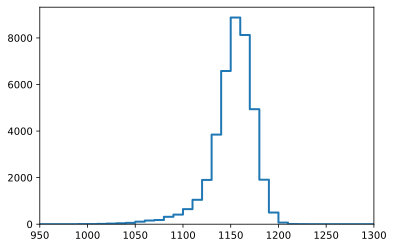

In [152]:
# Bin the EL light for each electron in mean binned map of x,y
plt.figure()
plt.hist(meta_avg["excitation"],  bins = np.arange(800, 1400, 10),histtype="step", linewidth=2,)
plt.xlim(950, 1300)

33


/Users/mistryk2/opt/anaconda3/envs/local/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


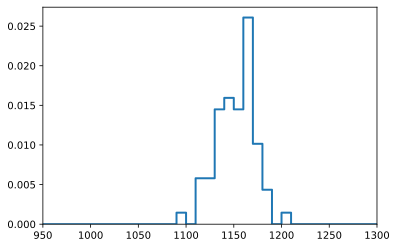

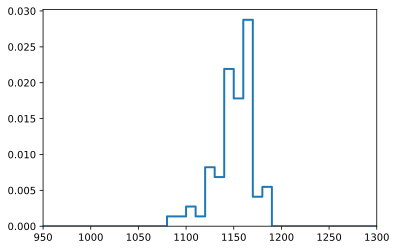

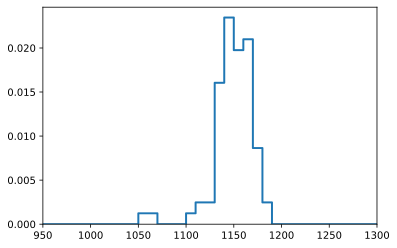

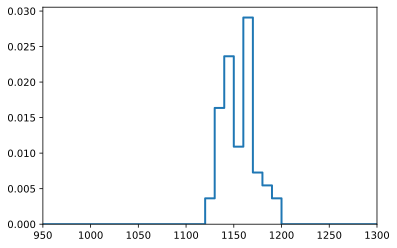

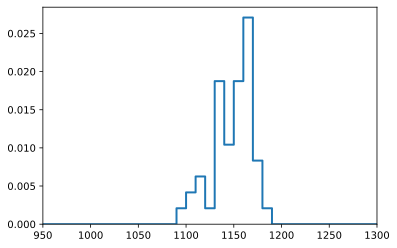

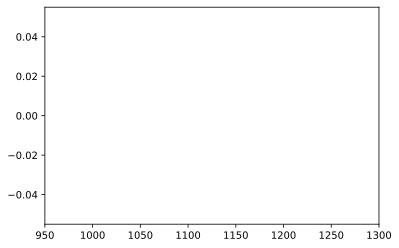

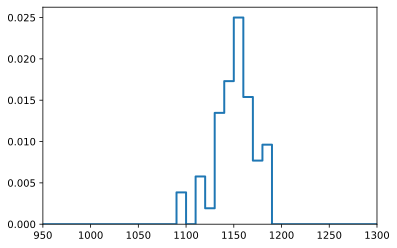

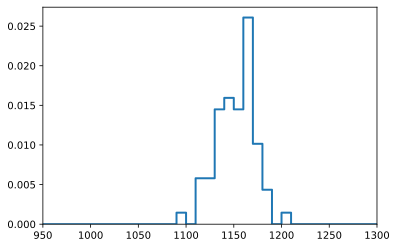

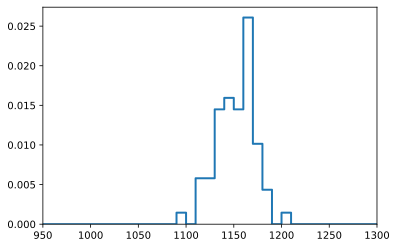

In [153]:
# Bin the EL light for each electron in mean binned map of x,y

index = 15 

print(len(meta_avg.q.unique()))

counter = 0 

for i in range(len(meta_avg.q.unique())):
    for j in range(len(meta_avg.r.unique())):

        counter+=1
        
        if (counter > 0  and counter < 10):
        
            plt.figure()
            plt.hist(meta_avg[(meta_avg["q"] == meta_avg.iloc[i].values[1]) & (meta_avg["r"] == meta_avg.iloc[j].values[2])]["excitation"],  bins = np.arange(800, 1400, 10),histtype="step",density = True, linewidth=2)
            plt.xlim(950, 1300)

# plt.hist(meta_avg[(meta_avg["q"] == meta_avg.iloc[index].values[1]) & (meta_avg["r"] == meta_avg.iloc[index].values[2])],  bins = np.arange(800, 1400, 10),histtype="step",density = True, linewidth=2)
# plt.xlim(1050, 1300)

# print(len(meta_avg[(meta_avg["q"] == meta_avg.iloc[index].values[1]) & (meta_avg["r"] == meta_avg.iloc[index].values[2])]))

(1050.0, 1300.0)

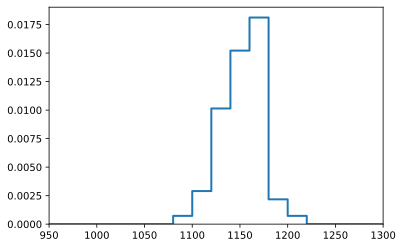

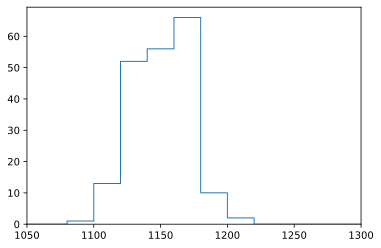

In [154]:
# Test numpy choice function\
bin_width =20


plt.hist(meta_avg[(meta_avg["q"] == meta_avg.iloc[0].values[1]) & (meta_avg["r"] == meta_avg.iloc[9].values[2])]["excitation"],  bins = np.arange(800, 1400, bin_width),histtype="step",density = True, linewidth=2)
plt.xlim(950, 1300)


bin_centers =  np.arange(810, 1390, bin_width)
hist, edges = np.histogram(meta_avg[(meta_avg["q"] == meta_avg.iloc[0].values[1]) & (meta_avg["r"] == meta_avg.iloc[9].values[2])]["excitation"], bins = np.arange(800, 1400, bin_width), density=True)
hist = hist*bin_width

values = []

rng = np.random.default_rng()

for i in range (0, 200, 1):
    # Sample the distribution
    values.append(rng.choice(bin_centers, p = hist))


plt.figure()
plt.hist(values,bins = np.arange(800, 1400, bin_width),histtype="step",)
plt.xlim(1050, 1300)



